In [2]:
import pandas as pd
import numpy as np
import os
import glob
import zipfile
import pyarrow.parquet as pq
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import warnings
from config import FAILED_BANK_LIST_FILE, CROSSWALK_CSV, UBPR_PANEL_FILE, REPORTS_DIR, PROCESSED_DATA_DIR, ANALYSIS_DATA_FILE




In [2]:
warnings.filterwarnings('ignore')


# Read in analysis data

In [ ]:
print("Loading Analysis Data...")
df = pd.read_parquet(ANALYSIS_DATA_FILE)
print("Analysis Data Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())

# Logistic regression model with ridge penalty

- For simplicity, We use only the most available data
- This makes the data less imbalanced
- Avoid the need to deal with intra bank correlation 

In [ ]:
# Step 0: Keep only the latest observation per bank
final_model_sorted = df.sort_values(['ID RSSD', 'Reporting Period'])
final_model_latest = df.groupby('ID RSSD').tail(1).reset_index(drop=True)

In [41]:

# Step 1: Select predictors and target

features = [
    'Tier1_Leverage_Ratio', 'Total_Risk_Based_Capital_Ratio',
       'Cash_Dividends_to_Net_Income', 'Noncurrent_Loans_OREO_to_Tier1_ACL',
       'Tier1_Capital_Growth_Rate', 'ACL_to_Loans_Leases_HFI',
       'ACL_to_Net_Loan_Losses', 'ACL_to_Nonaccrual_Loans_Leases',
       'Loans_30_89_Days_Past_Due_Ratio', 'Noncurrent_Loans_to_Gross_Loans',
       'Noncurrent_Loans_OREO_to_Loans_OREO', 'Net_Loan_Losses_to_Avg_Loans',
       'Earnings_Coverage_of_Net_Losses', 'Interest_Income_to_Avg_Assets',
       'Interest_Expense_to_Avg_Assets', 'Net_Interest_Income_to_Avg_Assets',
       'Noninterest_Income_to_Avg_Assets', 'Noninterest_Expense_to_Avg_Assets',
       'Pre_Provision_Net_Revenue_to_Avg_Assets',
       'Provision_Loan_Losses_to_Avg_Assets',
       'Provision_Other_Assets_Losses_to_Avg_Assets',
       'Pretax_Operating_Income_to_Avg_Assets',
       'Pretax_Net_Operating_Income_to_Avg_Assets',
       'Net_Operating_Income_to_Avg_Assets', 'Net_Income_to_Avg_Assets',
       'Net_Noncore_Funding_Dependence', 'Avg_Earning_Assets_to_Avg_Assets',
       'Avg_Interest_Bearing_Funds_to_Avg_Assets',
       'Short_Term_Noncore_Funding_Growth', 'Total_Assets_Annual_Change',
       'Net_Loans_Leases_Growth_Rate', 'Short_Term_Investments_Growth_Rate'
]

X = final_model_latest[features].copy()
y = final_model_latest["FAIL_FLAG"].astype(int)

# Handle missing values
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median())

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Logistic Regression with Ridge regularization
logreg = LogisticRegression(
    penalty='l2',
    C=1.0,               # Regularization strength (1.0 = default)
    class_weight='balanced',
    solver='liblinear',  # good for small datasets / binary classification
    random_state=42,
    max_iter=1000
)

logreg.fit(X_train_scaled, y_train)

# Step 4: Predictions
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))




Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2923
           1       0.72      0.89      0.80       151

    accuracy                           0.98      3074
   macro avg       0.86      0.94      0.89      3074
weighted avg       0.98      0.98      0.98      3074

ROC-AUC: 0.9796362713623171


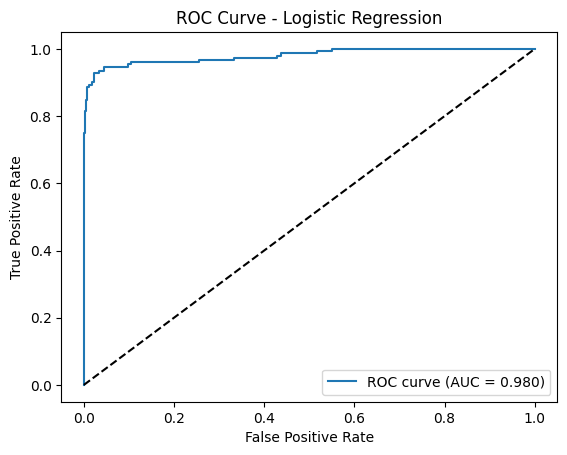

In [42]:
# Step 5: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_pred_prob):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()



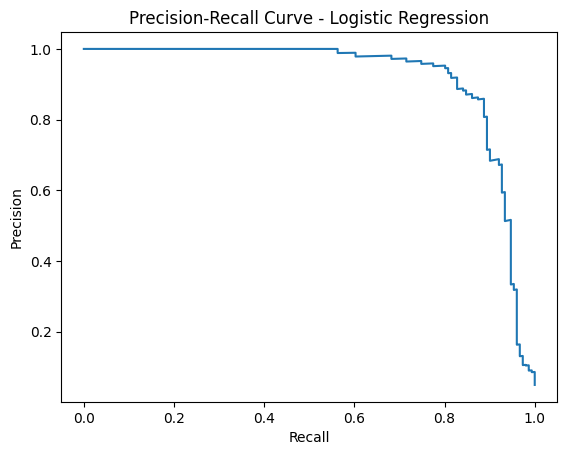

In [43]:
# Step 6: Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.show()



In [44]:
# Step 7: Feature importance (coefficients)
importances = pd.DataFrame({
    "Variable": features,
    "Coefficient": logreg.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\nTop predictors of failure (by absolute coefficient):")
print(importances.head(15))


Top predictors of failure (by absolute coefficient):
                                     Variable  Coefficient
0                        Tier1_Leverage_Ratio    -9.954815
1              Total_Risk_Based_Capital_Ratio    -1.633393
12            Earnings_Coverage_of_Net_Losses    -1.320100
4                   Tier1_Capital_Growth_Rate    -1.319446
21      Pretax_Operating_Income_to_Avg_Assets     1.122994
22  Pretax_Net_Operating_Income_to_Avg_Assets    -1.094262
18    Pre_Provision_Net_Revenue_to_Avg_Assets     1.057497
27   Avg_Interest_Bearing_Funds_to_Avg_Assets     0.863009
7              ACL_to_Nonaccrual_Loans_Leases    -0.851975
23         Net_Operating_Income_to_Avg_Assets    -0.723570
17          Noninterest_Expense_to_Avg_Assets    -0.709374
29                 Total_Assets_Annual_Change     0.646043
10        Noncurrent_Loans_OREO_to_Loans_OREO     0.634715
24                   Net_Income_to_Avg_Assets    -0.517289
19        Provision_Loan_Losses_to_Avg_Assets    -0.447025


In [45]:
# Step 8: Optimize threshold for F1-score
thresholds = np.linspace(0, 1, 101)
f1_scores = []

for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

best_t = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1:", best_t)
print("Best F1-score:", max(f1_scores))


Best threshold for F1: 0.8200000000000001
Best F1-score: 0.8729641693811075


In [46]:
# Step 9: Predictions
y_pred_prob = logreg.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_prob >= 0.9).astype(int)

print("Classification Report (threshold=0.9):")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))

Classification Report (threshold=0.9):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2923
           1       0.87      0.86      0.87       151

    accuracy                           0.99      3074
   macro avg       0.93      0.93      0.93      3074
weighted avg       0.99      0.99      0.99      3074

ROC-AUC: 0.9796362713623171


# LightGBM


In [47]:
# Step 0: Keep only the latest observation per bank
final_model_sorted = final_model.sort_values(['ID RSSD', 'Reporting Period'])
final_model_latest = final_model_sorted.groupby('ID RSSD').tail(1).reset_index(drop=True)

In [48]:
# Step 1: Select predictors and target (same as your original code)
features = [
    'Tier1_Leverage_Ratio', 'Total_Risk_Based_Capital_Ratio',
       'Cash_Dividends_to_Net_Income', 'Noncurrent_Loans_OREO_to_Tier1_ACL',
       'Tier1_Capital_Growth_Rate', 'ACL_to_Loans_Leases_HFI',
       'ACL_to_Net_Loan_Losses', 'ACL_to_Nonaccrual_Loans_Leases',
       'Loans_30_89_Days_Past_Due_Ratio', 'Noncurrent_Loans_to_Gross_Loans',
       'Noncurrent_Loans_OREO_to_Loans_OREO', 'Net_Loan_Losses_to_Avg_Loans',
       'Earnings_Coverage_of_Net_Losses', 'Interest_Income_to_Avg_Assets',
       'Interest_Expense_to_Avg_Assets', 'Net_Interest_Income_to_Avg_Assets',
       'Noninterest_Income_to_Avg_Assets', 'Noninterest_Expense_to_Avg_Assets',
       'Pre_Provision_Net_Revenue_to_Avg_Assets',
       'Provision_Loan_Losses_to_Avg_Assets',
       'Provision_Other_Assets_Losses_to_Avg_Assets',
       'Pretax_Operating_Income_to_Avg_Assets',
       'Pretax_Net_Operating_Income_to_Avg_Assets',
       'Net_Operating_Income_to_Avg_Assets', 'Net_Income_to_Avg_Assets',
       'Net_Noncore_Funding_Dependence', 'Avg_Earning_Assets_to_Avg_Assets',
       'Avg_Interest_Bearing_Funds_to_Avg_Assets',
       'Short_Term_Noncore_Funding_Growth', 'Total_Assets_Annual_Change',
       'Net_Loans_Leases_Growth_Rate', 'Short_Term_Investments_Growth_Rate'
]

X = final_model_latest[features].copy()
y = final_model_latest["FAIL_FLAG"].astype(int)

# Handle missing values
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(X.median())

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Step 3: LightGBM classifier 
lgbm = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=-1,
    class_weight="balanced",
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)

# Step 4: Predictions
y_pred_prob = lgbm.predict_proba(X_test)[:, 1]
y_pred = (y_pred_prob >= 0.5).astype(int)

print("Classification Report (threshold=0.5):")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))




[LightGBM] [Info] Number of positive: 352, number of negative: 6820
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7939
[LightGBM] [Info] Number of data points in the train set: 7172, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.968506	valid_0's binary_logloss: 0.0402836
[200]	valid_0's auc: 0.979867	valid_0's binary_logloss: 0.0549438
Early stopping, best iteration is:
[100]	valid_0's auc: 0.968506	valid_0's binary_logloss: 0.0402836
Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     

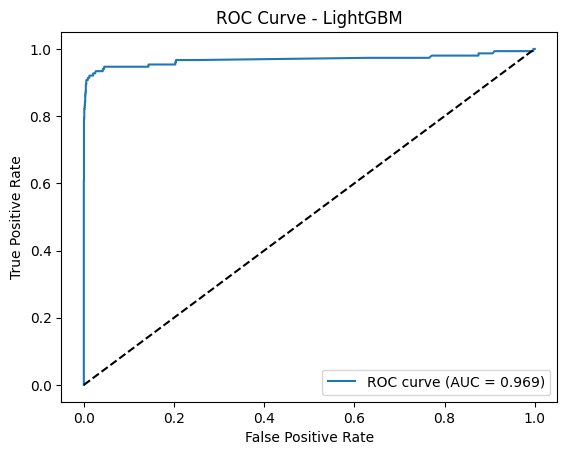

In [49]:
# Step 5: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc_score(y_test, y_pred_prob):.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - LightGBM")
plt.legend()
plt.show()

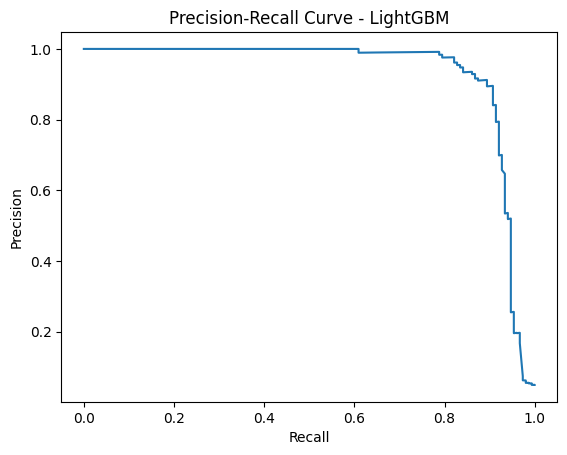

In [50]:


# Step 6: Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LightGBM")
plt.show()


In [51]:
# Step 7: Feature importance
importances = pd.DataFrame({
    "Variable": features,
    "Importance": lgbm.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop predictors of failure:")
print(importances.head(15))


Top predictors of failure:
                                    Variable  Importance
3         Noncurrent_Loans_OREO_to_Tier1_ACL         230
1             Total_Risk_Based_Capital_Ratio         225
8            Loans_30_89_Days_Past_Due_Ratio         194
0                       Tier1_Leverage_Ratio         190
14            Interest_Expense_to_Avg_Assets         179
27  Avg_Interest_Bearing_Funds_to_Avg_Assets         178
9            Noncurrent_Loans_to_Gross_Loans         176
29                Total_Assets_Annual_Change         147
25            Net_Noncore_Funding_Dependence         145
19       Provision_Loan_Losses_to_Avg_Assets         145
31        Short_Term_Investments_Growth_Rate         121
28         Short_Term_Noncore_Funding_Growth          99
5                    ACL_to_Loans_Leases_HFI          91
15         Net_Interest_Income_to_Avg_Assets          88
11              Net_Loan_Losses_to_Avg_Loans          80
